In [0]:
# !pip uninstall -q pyarrow
# !pip uninstall -q pickle5
# !pip install -q ray[debug]


In [0]:
from ray import tune

In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

import spacy

from torch.autograd import Variable

import time
import copy
from torch.optim import lr_scheduler

from torchtext.vocab import Vectors, GloVe
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import plot

In [3]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [0]:
X = df['headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [6]:
!mkdir torchtext_data

mkdir: cannot create directory ‘torchtext_data’: File exists


In [0]:
train_data.to_csv("torchtext_data/train.csv", index=False)
test_data.to_csv("torchtext_data/test.csv", index=False)

In [0]:
fix_length = 24
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 22895
Number of testing examples: 5724


In [0]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))

In [0]:
LABEL.build_vocab(train_data)

In [14]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 24479
Unique tokens in LABEL vocabulary: 2


In [0]:
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

from LSTM import *

In [0]:
def train(model, criterion, optimizer, train_iterator, batch_size):

    model.train()  # Set model to training mode
    phase = 'train'
    # Iterate over data.
    for batch in train_iterator:
                
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward
      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
        text = batch.Text
        label = batch.Label
        label = torch.autograd.Variable(label).long()

        if torch.cuda.is_available():
          text = text.cuda()
          label = label.cuda()
        if (batch.Text.size()[1] is not batch_size):
          continue
                    
        outputs = model(text)

        outputs = F.softmax(outputs,dim=-1)
                    
        loss = criterion(outputs, label)

        # backward + optimize only if in training phase
                        
        loss.backward()
        optimizer.step()

In [0]:
def test(model, criterion, optimizer, test_iterator, batch_size, test_size):

    model.eval()   # Set model to evaluate mode

    sentiment_corrects = 0
    phase = 'val'
    for batch in test_iterator:
                
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
          text = batch.Text
          label = batch.Label
          label = torch.autograd.Variable(label).long()

          if torch.cuda.is_available():
              text = text.cuda()
              label = label.cuda()
          if (batch.Text.size()[1] is not batch_size):
              continue
                    
          outputs = model(text)
          outputs = F.softmax(outputs,dim=-1)
                    
          loss = criterion(outputs, label)

          # statistics

          sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == label) 
          sentiment_acc = float(sentiment_corrects) / test_size

    return sentiment_acc

In [0]:
def train_lstm(config):

    batch_size = 16
    word_embeddings = TEXT.vocab.vectors
    output_size = 2
    num_layers = 1
    hidden_size = config["hidden_size"]
    embedding_length = 300
    vocab_size = len(TEXT.vocab)

    train_data, test_data = data.TabularDataset.splits(
      path="/content/torchtext_data/", train="train.csv", 
      test="test.csv",format="csv", skip_header=True, 
      fields=[('Text', TEXT), ('Label', LABEL)]
      )
    
    train_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, test_data), sort_key=lambda x: len(x.Text),
      batch_size=batch_size,
      device=device)
    
    test_size = len(test_data)

    model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    model = model.to(device)
    criterion = criterion.to(device)

    for i in range(10):
        train(model, criterion, optimizer, train_iterator, batch_size)
        acc = test(model, criterion, optimizer, test_iterator, batch_size, test_size)
        # Add logging statement here.
        tune.track.log(mean_accuracy=acc)

In [0]:
space = {
    "lr": hp.loguniform("lr", np.log(0.001), np.log(0.00005)),
    "weight_decay": hp.uniform("weight_decay", 1e-5, 1e-4),
    "hidden_size": hp.choice("hidden_size", [32, 64, 128])
}

In [0]:
hyperopt_search = HyperOptSearch(space, max_concurrent=5, metric="mean_accuracy", mode="max")

In [21]:
analysis = tune.run(
    train_lstm, 
    num_samples=16,  
    search_alg=hyperopt_search,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    verbose=1,
    resources_per_trial={"cpu": 2, "gpu": 1}
)

Trial name,status,loc,lr,weight_decay,hidden_size,iter,total time (s),acc
train_lstm_cec0f00a,TERMINATED,,0.000551837,9.72328e-05,64,9,112.074,0.852201
train_lstm_cf7ee632,TERMINATED,,0.000237535,6.97123e-05,64,1,33.0923,0.790706
train_lstm_d0351aba,TERMINATED,,0.000166456,9.83462e-05,128,1,33.7733,0.772013
train_lstm_d0f0ddd6,TERMINATED,,0.000735792,3.21844e-05,64,4,62.7638,0.842942
train_lstm_d1ad1aa0,TERMINATED,,0.000142782,6.97006e-05,64,1,33.4386,0.769916
train_lstm_d26a04a8,TERMINATED,,0.000927294,1.11936e-05,32,4,62.8061,0.846087
train_lstm_191f2c02,TERMINATED,,0.000513134,4.3997e-05,32,1,33.4202,0.818134
train_lstm_2fcecd4a,TERMINATED,,0.000826127,1.60103e-05,32,4,62.8595,0.845038
train_lstm_474a25c8,TERMINATED,,0.000146611,2.58397e-05,64,1,33.4719,0.776555
train_lstm_7009516e,TERMINATED,,0.000570429,1.84339e-05,32,1,33.3012,0.800489


2020-01-08 12:01:52,244	INFO tune.py:334 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


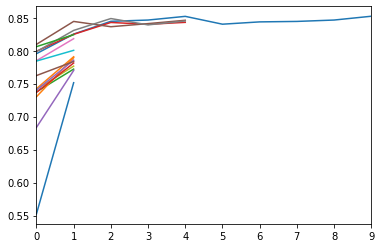

In [22]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)


In [0]:
from AttantionLSTM import *

In [0]:
def train_att_lstm(config):

    batch_size = 16
    word_embeddings = TEXT.vocab.vectors
    output_size = 2
    num_layers = 1
    hidden_size = config["hidden_size"]
    embedding_length = 300
    vocab_size = len(TEXT.vocab)

    train_data, test_data = data.TabularDataset.splits(
      path="/content/torchtext_data/", train="train.csv", 
      test="test.csv",format="csv", skip_header=True, 
      fields=[('Text', TEXT), ('Label', LABEL)]
      )
    
    train_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, test_data), sort_key=lambda x: len(x.Text),
      batch_size=batch_size,
      device=device)
    
    test_size = len(test_data)

    model = AttantionLSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    model = model.to(device)
    criterion = criterion.to(device)

    for i in range(10):
        train(model, criterion, optimizer, train_iterator, batch_size)
        acc = test(model, criterion, optimizer, test_iterator, batch_size, test_size)
        # Add logging statement here.
        tune.track.log(mean_accuracy=acc)

In [0]:
space = {
    "lr": hp.loguniform("lr", np.log(0.001), np.log(0.00005)),
    "weight_decay": hp.uniform("weight_decay", 1e-5, 1e-4),
    "hidden_size": hp.choice("hidden_size", [32, 64, 128])
}

In [0]:
hyperopt_search = HyperOptSearch(space, max_concurrent=5, metric="mean_accuracy", mode="max")

In [27]:
analysis_att = tune.run(
    train_att_lstm, 
    num_samples=16,  
    search_alg=hyperopt_search,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    verbose=1,
    resources_per_trial={"cpu": 2, "gpu": 1}
)

Trial name,status,loc,lr,weight_decay,hidden_size,iter,total time (s),acc
train_att_lstm_c53e647e,TERMINATED,,0.000325071,1.70635e-05,64,9,66.9333,0.857617
train_att_lstm_c5f1836a,TERMINATED,,0.00019152,6.52311e-05,32,1,24.0623,0.804682
train_att_lstm_c6a3f43c,TERMINATED,,8.94241e-05,9.92408e-05,128,1,24.347,0.786688
train_att_lstm_c7571008,TERMINATED,,0.000791313,4.58864e-05,32,9,65.0351,0.864081
train_att_lstm_c80da69c,TERMINATED,,0.000514796,3.70246e-05,32,4,39.5311,0.853075
train_att_lstm_c8c1dc52,TERMINATED,,0.000779135,4.12996e-05,128,1,24.3947,0.607792
train_att_lstm_f3f2c698,TERMINATED,,0.000171891,6.64203e-05,128,1,24.382,0.816562
train_att_lstm_05a1fbac,TERMINATED,,0.000300024,4.0482e-05,64,4,39.7019,0.828791
train_att_lstm_179036a8,TERMINATED,,0.000114338,7.29056e-05,32,1,24.5679,0.795423
train_att_lstm_4205ce70,TERMINATED,,0.000129729,8.50835e-05,64,1,24.0136,0.79717


2020-01-08 12:19:58,667	INFO tune.py:334 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


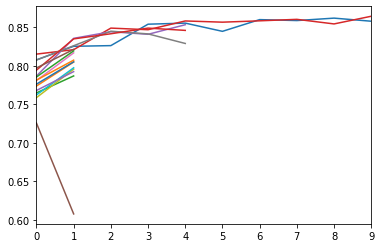

In [28]:
dfs = analysis_att.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [0]:
from BidiractionalLSTM import *

In [0]:
def train_bi_lstm(config):

    batch_size = 16
    word_embeddings = TEXT.vocab.vectors
    output_size = 2
    num_layers = 1
    hidden_size = config["hidden_size"]
    embedding_length = 300
    vocab_size = len(TEXT.vocab)

    train_data, test_data = data.TabularDataset.splits(
      path="/content/torchtext_data/", train="train.csv", 
      test="test.csv",format="csv", skip_header=True, 
      fields=[('Text', TEXT), ('Label', LABEL)]
      )
    
    train_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, test_data), sort_key=lambda x: len(x.Text),
      batch_size=batch_size,
      device=device)
    
    test_size = len(test_data)

    model = BidirectionalLSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    model = model.to(device)
    criterion = criterion.to(device)

    for i in range(10):
        train(model, criterion, optimizer, train_iterator, batch_size)
        acc = test(model, criterion, optimizer, test_iterator, batch_size, test_size)
        # Add logging statement here.
        tune.track.log(mean_accuracy=acc)

In [0]:
space = {
    "lr": hp.loguniform("lr", np.log(0.001), np.log(0.00005)),
    "weight_decay": hp.uniform("weight_decay", 1e-5, 1e-4),
    "hidden_size": hp.choice("hidden_size", [32, 64, 128])
}

In [0]:
hyperopt_search = HyperOptSearch(space, max_concurrent=5, metric="mean_accuracy", mode="max")

In [33]:
analysis_bi = tune.run(
    train_bi_lstm, 
    num_samples=16,  
    search_alg=hyperopt_search,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    verbose=1,
    resources_per_trial={"cpu": 2, "gpu": 1}
)

Trial name,status,loc,lr,weight_decay,hidden_size,iter,total time (s),acc
train_bi_lstm_46112e22,TERMINATED,,6.59281e-05,1.51984e-05,32,9,85.3758,0.81499
train_bi_lstm_46cca724,TERMINATED,,0.00070061,3.95744e-05,128,9,88.701,0.857966
train_bi_lstm_47839556,TERMINATED,,5.6321e-05,9.42306e-05,64,1,28.74,0.739518
train_bi_lstm_483ae1de,TERMINATED,,0.000946381,6.24615e-05,64,1,28.5275,0.642208
train_bi_lstm_48f03b38,TERMINATED,,5.20975e-05,3.28375e-05,32,1,28.4568,0.685535
train_bi_lstm_49a7403a,TERMINATED,,0.000632791,9.50258e-05,128,9,88.8747,0.863033
train_bi_lstm_7fecb800,TERMINATED,,0.000195301,6.26883e-05,128,4,50.279,0.840671
train_bi_lstm_b81712a2,TERMINATED,,0.000259159,7.77303e-05,128,1,28.6686,0.791579
train_bi_lstm_cc912042,TERMINATED,,0.000220337,4.50694e-05,64,4,51.5709,0.846087
train_bi_lstm_e0fdc47c,TERMINATED,,0.000935225,3.87604e-05,64,9,88.3042,0.869846


2020-01-08 12:43:00,235	INFO tune.py:334 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


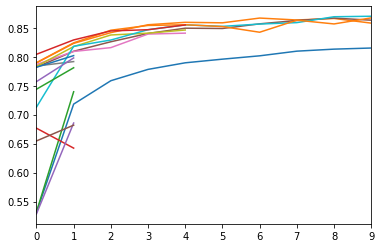

In [34]:
dfs = analysis_bi.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)